## libs

In [52]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math as m
import scipy.integrate as integrate

## constants

In [53]:
cm_in_pc = 206264.8 * 149.6e11  # cm

freq_ion = 3.29E15  # Herz
#freq_max = 5.0E16  # Herz
freq_init =  1.5e13
freq_max = 1.31e16
alpha = 2.59E-13  # cm^3 per sec
temperature = 35000  # Kelvins
radius_star =  20 * 695e8 / cm_in_pc  # pc
r_inner = 0.05  # pc
step = 0.005  # pc

c = 2.99792458E10  # cm per sec, light speed
h = 6.626070040812E-27  # erg*sec, Planck constant
k = 1.380648528E-16  # erg/K, Boltzmann constant
nH_total = 100  # cm^(-3)

## variables

In [61]:
freq = np.geomspace (freq_ion, freq_max, 300)
freq_tau = pd.DataFrame(data = {
    "freq" : freq,
    "tau_previous" : np.full(300, 0),
    "tau_current" : np.full(300, 0)})

result = pd.DataFrame(data = {
    "r" : [],
    "n_e" : []})

r_current = r_inner 
check = True
kuru = pd.read_csv("kuru_35000.txt", delimiter=' ')

choose what model of spectra is needed

In [62]:
model = 'kuru' # 'kuru' or 'planck'

In [63]:
kuru['freq'] = c / kuru['lambda'] * 1e7
kuru['flux_lambda'] = pow(10, kuru['logF'])  
kuru['flux_nu'] = kuru['flux_lambda'] * c / kuru['freq']**2 * 1e7
kuru['brightness'] = kuru['flux_nu']
kuru.sort_values('freq', inplace=True)

## functions

In [64]:
def brightness(freq, model):
    """Return mean brightness as a function of frequency for continuum or non-continuum case"""
    if model == 'planck':
        return 2 * h * freq**3 / c**2 / (np.exp(h * freq / (k * temperature)) - 1)
    elif model == 'kuru':
        return np.interp(freq, kuru['freq'], kuru['brightness'])
    else:
        print('smth bad happened')

def sigma(freq):
    """Return photoionization cross section"""
    return 6.3E-18 * np.power (freq_ion / freq, 3)

def tau_step(freq_tau):
    """Return additional opacity caused by distance's step"""
    
    tau_new = 2 * freq_tau['tau_current'] - freq_tau['tau_previous']
    freq_tau['tau_previous'] = freq_tau['tau_current']
    freq_tau['tau_current'] = tau_new 

def tau(result, freq, n_e):
    """Return opacity on a distance r"""
    
    nH_ionized = nH_total - result["n_e"]
    distance = result["r"] * cm_in_pc
    
    return integrate.trapz(y=nH_ionized, x=distance) * sigma(freq)

## Planck's and Kurucz's spectra

Text(0.5, 0, 'Frequency, Herz')

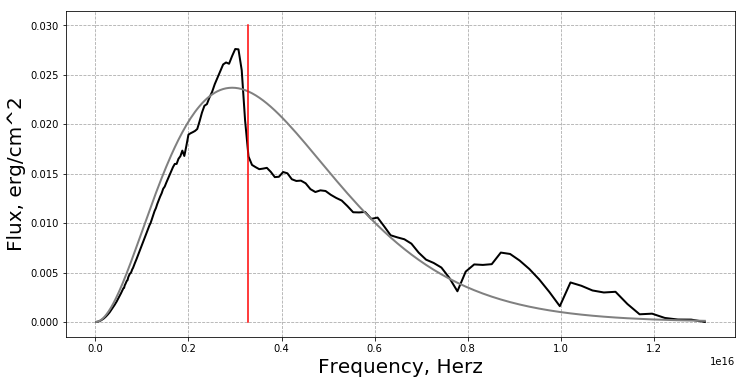

In [65]:
freq_plot = np.geomspace (freq_init, freq_max, 300)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(freq_plot,brightness(freq_plot, 'kuru'), lw=2, c='black')
ax.plot(freq_plot,brightness(freq_plot, 'planck'), lw=2, c='grey')
ax.plot([freq_ion, freq_ion], [0,0.03], c='red')
ax.grid(c='#aaaaaa', ls='--')
plt.ylabel("Flux, erg/cm^2", size=20)
plt.xlabel("Frequency, Herz", size=20)

## algorithm

In [66]:
n_e = nH_total

while np.abs(n_e) > 0.0001:
    check = True
    while check:
        
        PHI = integrate.trapz(m.pi * brightness(freq,model) *
                             (radius_star / r_current)**2 *
                              np.exp(-freq_tau['tau_current']) *
                              sigma(freq) / (h * freq),
                              freq)
        
        ksi = PHI / (n_e * alpha)
        nH_neutral = nH_total / (1 + ksi)
        nH_ionized = nH_total * ksi / (1 + ksi)
        n_e_new = np.sqrt(n_e * nH_ionized)
        if np.abs(n_e_new / n_e - 1) < 0.1E-5:
            n_e = n_e_new
            df = pd.DataFrame(data={'r': [r_current],
                                    "n_e": [n_e],
                                    "nH_neutral": [nH_neutral],
                                    "PHI": [PHI]})
            result = result.append(df, ignore_index=True, sort=False)
            check = False
        else:
            n_e = n_e_new
            freq_tau["tau_current"] = tau(result, freq, n_e) 
    
    nH_neutral = nH_total - n_e
    freq_tau["tau_current"] = tau(result, freq, n_e) 
    tau_step(freq_tau)
    r_current += step    

## plot

Text(0.5, 0, 'r, pc')

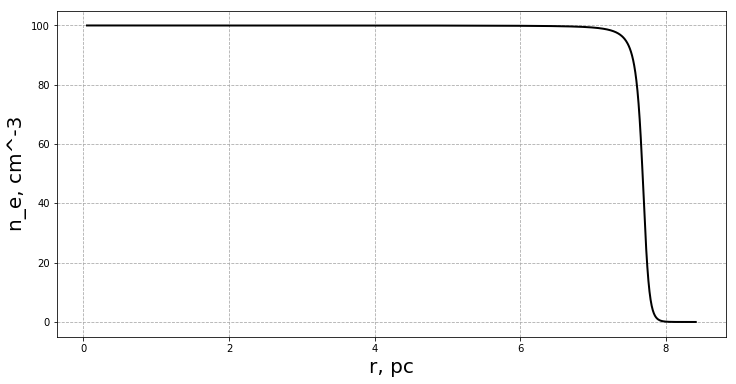

In [67]:
fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(result['r'], result['n_e'], lw=2, c='black') 
ax.grid(c='#aaaaaa', ls='--')
plt.ylabel("n_e, cm^-3", size=20)
plt.xlabel("r, pc", size=20)